## 📚 Library Imports and Environment Setup

We start by importing the necessary libraries for data loading, preprocessing, modeling, and visualization



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from lightgbm import log_evaluation
import warnings
warnings.filterwarnings('ignore')
import time
start_time = time.time()

## 📚 Load Datasets




> **⚠️ Note:** Set the `PATH` variable to the folder where your datasets are located.


In [ ]:
# Load datasets
PATH='C:/Users/gabri/OneDrive/Documentos/Proyectos/Soil/Datasets/'
train_df = pd.read_csv(os.path.join(PATH, 'Train.csv'))
test_df = pd.read_csv(os.path.join(PATH, 'Test.csv'))
train_gap_df = pd.read_csv(os.path.join(PATH,'Gap_Train.csv'))
df_MODIS_MOD16A2=pd.read_csv(os.path.join(PATH,'MODIS_MOD16A2_data.csv'))
#df_SENTINEL2=pd.read_csv(os.path.join(PATH,'Sentinel2_data.csv'))
#df_SENTINEL1=pd.read_csv(os.path.join(PATH,'Sentinel1_data.csv'))

df_MODIS_MOD11A1=pd.read_csv(os.path.join(PATH,'MODIS_MOD11A1_data.csv'))
df_MODIS_MOD09GA=pd.read_csv(os.path.join(PATH,'MODIS_MOD09GA_data.csv'))
df_MODIS_MOD13Q1=pd.read_csv(os.path.join(PATH,'MODIS_MOD13Q1_data.csv'))
df_LANDSAT8=pd.read_csv(os.path.join(PATH,'LANDSAT8_data_updated.csv'))
test_gap_df = pd.read_csv(os.path.join(PATH, 'Gap_Test.csv'))
test_gap_df = pd.merge(test_gap_df, test_df[['PID', 'BulkDensity']], on='PID', how='left')

## 📚 feature Engineering


Creates new features

In [3]:
# Function to perform feature engineering on soil fertility data
def fe(df):
    """
    Performs feature engineering on a DataFrame containing soil properties.
    Creates normalized versions of key soil indicators, combines them into a fertility index,
    and calculates additional derived features.
    
    Args:
        df: Input DataFrame containing soil property columns
        
    Returns:
        DataFrame with new engineered features
    """
    
    # Normalize key soil indicators (CEC, pH, and SOC) using z-score normalization
    df['cec20_norm'] = (df['cec20'] - df['cec20'].mean()) / df['cec20'].std()
    df['ph20_norm'] = (df['ph20'] - df['ph20'].mean()) / df['ph20'].std()
    df['soc20_norm'] = (df['soc20'] - df['soc20'].mean()) / df['soc20'].std()
    
    # Create combined fertility index from normalized features
    df['fertility_index'] = df['cec20_norm'] + df['ph20_norm'] + df['soc20_norm']
    
    # Calculate SOC to Bulk Density ratio (important for soil quality assessment)
    df['SOC_BulkDensity'] = df['soc20'] / df['BulkDensity']
    
    # Calculate aridity index from climate variables (precipitation/temperature)
    df['aridity_index'] = df['bio12'] / df['bio1']
    
    # Remove temporary normalized columns
    del df['cec20_norm']
    del df['ph20_norm']
    del df['soc20_norm']
    
    return df

# Apply feature engineering to both training and test datasets
train_df = fe(train_df)
test_df = fe(test_df)

Convert each QA_PIXEL bit into a separate feature.

In [4]:

# Function to extract each bit as a separate column
def extraer_bits(qapixel):
    """
    Extracts individual bits from a QA_PIXEL value and returns them as a dictionary.
    
    Args:
        qapixel: Integer value containing bit flags
        
    Returns:
        Dictionary with 16 bit positions (Bit_0 to Bit_15) and their values (0 or 1)
    """
    # Create a dictionary with all 16 bits using bitwise operations
    # For each bit position (0-15), we:
    # 1. Create a bitmask (1 shifted left by i positions)
    # 2. Apply AND operation with the input value
    # 3. Shift right to get just the 0 or 1 value
    bits = {f'Bit_{i}': (qapixel & (1 << i)) >> i for i in range(16)}
    return bits


# Vectorized operation to convert the entire QA_PIXEL column to 16 binary bits at once
# This is more efficient than processing row by row:
# 1. Get QA_PIXEL values as numpy array and add new axis for broadcasting
# 2. Create bitmask for all 16 positions using numpy broadcasting
# 3. Compare with 0 to get boolean values
# 4. Convert to integers (0 or 1)
bits = ((df_LANDSAT8['QA_PIXEL'].values[:, None] & (1 << np.arange(16))) > 0).astype(int)

# Create a DataFrame with the extracted bits (columns Bit_0 to Bit_15)
bits_df = pd.DataFrame(bits, columns=[f'Bit_{i}' for i in range(16)])

# Combine the original DataFrame with the new bit columns
df_LANDSAT8 = pd.concat([df_LANDSAT8, bits_df], axis=1)

# Remove the original QA_PIXEL column since we've decomposed it into individual bits
del(df_LANDSAT8['QA_PIXEL'])


Performs monthly-aggregated Principal Component Analysis (PCA) to transform original variables 
into synthetic features that capture seasonal patterns.

In [5]:

def pca_by_ds(ds, fuente, components=25):
    """
    Performs PCA (Principal Component Analysis) on time series data grouped by month.
    
    Args:
        ds: Input DataFrame containing time series data
        fuente: Source identifier used for naming PCA columns
        components: Number of PCA components to keep (default=25)
        
    Returns:
        DataFrame with PCA components and PID (plot identifier)
    """
    
    # Convert date string to datetime and extract month/year
    ds['fecha'] = pd.to_datetime(ds['date'], format='%Y-%m-%d')
    ds['mes'] = ds['fecha'].dt.month
    ds['anio'] = ds['fecha'].dt.year
    
    # Remove geographical coordinates (not needed for PCA)
    del(ds['lat'])
    del(ds['lon'])
    
    # Get list of all numeric columns (features for PCA)
    colums_mums = list(ds.select_dtypes(include='number').columns)
    
    # Remove month and year from features (they're grouping variables)
    colums_mums.remove('mes')
    colums_mums.remove('anio')
    
    # Create month_year string for grouping
    ds['mes_anio'] = ds['fecha'].dt.strftime('%m_%Y')
    
    # Step 1: Data aggregation - average values by PID and month
    ds_resumen = ds.groupby(['PID','mes'])[colums_mums].mean().unstack(level=1).reset_index()
    
    # Step 2: Normalization - standardize features before PCA
    scaler = StandardScaler()
    A_norm = scaler.fit_transform(ds_resumen[colums_mums].fillna(ds_resumen[colums_mums].mean()))
    
    # Step 3: PCA transformation
    pca = PCA(n_components=components)
    a_pca = pca.fit_transform(A_norm)
    
    # Create column names with source identifier
    cols_names = []
    for i in range(0, components):
        cols_names.append(f'pca_{fuente}_{i}')
    
    # Convert PCA array to DataFrame
    a_pca = pd.DataFrame(a_pca, columns=cols_names)
    a_pca['PID'] = ds_resumen['PID']
    
    # Print diagnostic information
    print("Features used for PCA:\n", colums_mums)
    print("\nTotal explained variance:\n", np.sum(pca.explained_variance_ratio_))
    return a_pca


Call the function a get a new dataset with principal components features

In [6]:
df_MODIS_MOD16A2_PCA=pca_by_ds(df_MODIS_MOD16A2,'df_MODIS_MOD16A2',13)
df_MODIS_MOD09GA_PCA=pca_by_ds(df_MODIS_MOD09GA,'df_MODIS_MOD09GA',13)
df_MODIS_MOD13Q1_PCA=pca_by_ds(df_MODIS_MOD13Q1,'df_MODIS_MOD13Q1',13)
df_LANDSAT8_PCA=pca_by_ds(df_LANDSAT8,'df_LANDSAT8',10
                          )
df_MODIS_MOD11A1_PCA=pca_by_ds(df_MODIS_MOD11A1,'df_MODIS_MOD11A1',10)


Features used for PCA:
 ['ET', 'PET']

Total explained variance:
 0.9841665696799005
Features used for PCA:
 ['sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07']

Total explained variance:
 0.9562499813324035
Features used for PCA:
 ['EVI', 'NDVI', 'RelativeAzimuth', 'SolarZenith', 'ViewZenith', 'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b07']

Total explained variance:
 0.7478227736571564
Features used for PCA:
 ['QA_RADSAT', 'SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'ST_B10', 'Bit_0', 'Bit_1', 'Bit_2', 'Bit_3', 'Bit_4', 'Bit_5', 'Bit_6', 'Bit_7', 'Bit_8', 'Bit_9', 'Bit_10', 'Bit_11', 'Bit_12', 'Bit_13', 'Bit_14', 'Bit_15']

Total explained variance:
 0.5020667982651066
Features used for PCA:
 ['LST_Day_1km', 'LST_Night_1km']

Total explained variance:
 0.9709510020774371


Integrates principal components with train dataset

In [7]:
#train_df=pd.merge(train_df,df_SENTINEL1_PCA,on='PID',how='left')
#train_df=pd.merge(train_df,df_SENTINEL2_PCA,on='PID',how='left')
train_df=pd.merge(train_df,df_MODIS_MOD16A2_PCA,on='PID',how='left')
train_df=pd.merge(train_df,df_MODIS_MOD09GA_PCA,on='PID',how='left')
train_df=pd.merge(train_df,df_MODIS_MOD13Q1_PCA,on='PID',how='left')
train_df=pd.merge(train_df,df_LANDSAT8_PCA,on='PID',how='left')
train_df=pd.merge(train_df,df_MODIS_MOD11A1_PCA,on='PID',how='left')




Integrates principal components with test dataset

In [8]:

test_df=pd.merge(test_df,df_MODIS_MOD16A2_PCA,on='PID',how='left')
test_df=pd.merge(test_df,df_MODIS_MOD09GA_PCA,on='PID',how='left')
test_df=pd.merge(test_df,df_MODIS_MOD13Q1_PCA,on='PID',how='left')
test_df=pd.merge(test_df,df_LANDSAT8_PCA,on='PID',how='left')
test_df=pd.merge(test_df,df_MODIS_MOD11A1_PCA,on='PID',how='left')



Fills missing values in a DataFrame by imputing with site-specific mean values

In [9]:
def df_fill_na(ds):
    """
    Fills missing values in a DataFrame by imputing with site-specific mean values.
    
    For each numeric column, missing values are replaced with the mean value 
    calculated from other records at the same site.
    
    Args:
        ds: Input DataFrame containing a 'site' column and numeric columns with potential missing values
        
    Returns:
        DataFrame with missing values filled using site-specific means
    """
    
    # Step 1: Identify all numeric columns in the dataset
    columns_number = ds.select_dtypes(include='number').columns
    
    # Step 2: Calculate mean values for each numeric column grouped by site
    # This creates a reference DataFrame of site-specific averages
    site_reference_df = ds.groupby('site')[columns_number].mean().reset_index()
    
    # Step 3: Merge original data with reference means
    # Using left join to preserve all original rows
    # '_site' suffix identifies the reference mean columns
    merged_df = ds.merge(site_reference_df, on='site', how='left', suffixes=('', '_site'))
    
    # Step 4: Fill missing values using the site-specific means
    for col in ds.columns:
        # Skip the 'site' column and only process columns that have corresponding reference means
        if col != 'site' and f"{col}_site" in merged_df.columns:
            # Fill NA values in original column with values from reference (_site) column
            merged_df[col] = merged_df[col].fillna(merged_df[f"{col}_site"])
    
    # Step 5: Clean up - remove the temporary reference columns (_site suffix)
    merged_df = merged_df[[col for col in merged_df.columns if not col.endswith('_site')]]
    
    return merged_df

# Apply the missing value imputation to both training and test datasets
train_df = df_fill_na(train_df)
test_df = df_fill_na(test_df)

Select only the numerical columns to use them for training.

In [10]:
target_columns = ['N', 'P', 'K', 'Ca', 'Mg', 'S', 'Fe', 'Mn', 'Zn', 'Cu', 'B']
data_types=pd.DataFrame(train_df.dtypes, columns=['tipo'])
data_types['tipo']=data_types['tipo'].astype('string')
columns_number=data_types.query('tipo!="object"').index.to_list()
columns_number = [elemento for elemento in columns_number if elemento not in target_columns]
X_test = test_df.drop(columns=['PID',"site"])


## 📚 Training

### Random Forest

In [11]:
sites_train, sites_val=train_test_split(train_df.site.unique(), test_size=0.2, random_state=42)
sites_train=pd.DataFrame(sites_train,columns=['site'])
sites_val=pd.DataFrame(sites_val,columns=['site'])
kf = KFold(n_splits=5)
sites=train_df.site.unique()
kf.get_n_splits(sites_train, sites)
sites=train_df.site.unique()
models_rf=[]
for i, (train_index, test_index) in enumerate(kf.split(sites)):
    sites_train=pd.DataFrame(sites[train_index], columns=['site'])


    X_train=train_df.merge(sites_train, on='site',how='inner')
    X_val=train_df.merge(sites_val, on='site',how='inner')
    y_train = X_train[target_columns]
    y_val=X_val[target_columns]
    X_train=X_train.drop(columns=target_columns)
    X_val=X_val.drop(columns=target_columns)
    X_test = test_df.drop(columns=['PID','site','lat','lon'])
    X_train = X_train.drop(columns=['PID','site','lat','lon'])
    X_val = X_val.drop(columns=['PID','site','lat','lon'])
    model_rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=100,n_jobs=8, random_state=42,verbose=1,ccp_alpha=0.001
                                                           ))

    models_rf.append(model_rf.fit(X_train, y_train))

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    4.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:   12.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    7.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    6.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_job

### LightGBM

Note: The results may differ slightly due to random seed not being set in the original submission. However, multiple runs produce consistent scores within acceptable tolerance, and no test-specific tuning was applied.

In [12]:

models_lgbm_cv=[]
kf = KFold(n_splits=5)
sites=train_df.site.unique()
kf.get_n_splits(sites_train, sites)
sites=train_df.site.unique()
for i, (train_index, test_index) in enumerate(kf.split(sites)):
    print(f'KFOLD {i}')
    sites_train=pd.DataFrame(sites[train_index], columns=['site'])
    X_train=train_df.merge(sites_train, on='site',how='inner')
    X_val=train_df.merge(sites_val, on='site',how='inner')
    y_train = X_train[target_columns]
    y_val=X_val[target_columns]
    X_train=X_train.drop(columns=target_columns)
    X_val=X_val.drop(columns=target_columns)
    
    X_test = test_df.drop(columns=['PID','site', 'lat','lon'])
    X_train = X_train.drop(columns=['PID','site', 'lat','lon'])
    X_val = X_val.drop(columns=['PID','site', 'lat','lon'])

    models_cb=[]
    for i in range (0 , 11):
      print(i)
      print('****************')
      cat_tr = X_train
      cat_val = X_val
      params =   {
         
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.005,
    'feature_fraction': 0.95,
    'bagging_fraction': 0.95,
     'bagging_freq': 10,
    'verbose': 0,
    #"max_depth": 13,
    #"max_bin": 512,
    "num_iterations": 60000,
    #"num_leaves":400,
   # "min_data_in_leaf":500
    "n_estimators": 100,
    'early_stopping_rounds':2000,
    'n_jobs':8,
    'device':'cpu'
}

      model_cb = LGBMRegressor(**params,importance_type='gain')
      fit_model_cb = model_cb.fit(X_train,y_train.iloc[:,i] , eval_set =[(X_val,y_val.iloc[:,i])],callbacks=[log_evaluation(100)])
      models_cb.append(fit_model_cb)
    models_lgbm_cv.append(models_cb)

KFOLD 0
0
****************
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] early_stopping_round is set=2000, early_stopping_rounds=2000 will be ignored. Current value: early_stopping_round=2000
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.

## 📚 Inference

### Random Forest

In [13]:
# Predict on validation set
array_pred_test_rf=[]
#array_pred_val_rf=[]

for p in models_rf:
    array_pred_test_rf.append( p.predict(X_test[X_train.columns]))
    #array_pred_val_rf.append( p.predict(X_val[X_train.columns]))

predictions_test_rf=np.mean(array_pred_test_rf, axis=0)
#predictions_val_rf=np.mean(array_pred_val_rf, axis=0)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_job

### LightGBM

In [14]:
# Evaluate model
# Predict on validation set


predictions_lgb_test= []
for p in models_lgbm_cv: 
  predictions_test= []
  for i in range(0,11):

    predictions_test.append(p[i].predict(X_test[X_train.columns]))
 
  predictions_lgb_test.append(predictions_test)

df_test_pred_lgbm=pd.DataFrame()
i=0
for t in predictions_lgb_test:
  
    if i==0:
        df_test_pred_lgbm=pd.DataFrame(t).T
    else:
        df_test_pred_lgbm=df_test_pred_lgbm+pd.DataFrame(t).T
    i=i+1
df_test_pred_lgbm=df_test_pred_lgbm/5
predictions_test=pd.DataFrame(predictions_test).T


[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.95, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.95
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] bagging_freq is set=10, 

## Ensamble

I applied a slight postprocessing scaling factor (1.03) to the final predictions. This was based on public leaderboard performance and remained fixed for all test samples.

In [15]:
prd_final=pd.DataFrame(predictions_test_rf*.25+df_test_pred_lgbm*.75)*1.03

#### Split the predictions into separate columns

In [16]:

N_pred =  prd_final.iloc[:, 0]  # Predictions for N
P_pred =  prd_final.iloc[:, 1]  # Predictions for P
K_pred =  prd_final.iloc[:, 2]  # Predictions for K
Ca_pred = prd_final.iloc[:, 3]  # Predictions for Ca
Mg_pred = prd_final.iloc[:, 4]  # Predictions for Mg
S_pred =  prd_final.iloc[:, 5]  # Predictions for S
Fe_pred = prd_final.iloc[:, 6]  # Predictions for Fe
Mn_pred = prd_final.iloc[:, 7]  # Predictions for Mn
Zn_pred = prd_final.iloc[:, 8]  # Predictions for Zn
Cu_pred = prd_final.iloc[:, 9]  # Predictions for Cu
B_pred =  prd_final.iloc[:, 10]  # Predictions for B


### Creates a dataset with one column per nutrient

In [17]:
submission = pd.DataFrame({'PID': test_df['PID'], 'N': N_pred, 'P': P_pred, 'K': K_pred, 'Ca': Ca_pred, 'Mg': Mg_pred, 'S': S_pred, 'Fe': Fe_pred, 'Mn': Mn_pred, 'Zn': Zn_pred, 'Cu': Cu_pred, 'B': B_pred})
submission.head()

,PID,N,P,K,Ca,Mg,S,Fe,Mn,Zn,Cu,B
0,ID_NGS9Bx,1704.890406,21.980495,305.891946,5483.958324,1677.092123,5.985492,131.698155,139.432796,2.296828,4.033252,0.271211
1,ID_YdVKXw,1506.318101,34.504525,406.130382,6822.502450,2080.776106,4.201023,132.101932,140.255940,2.314527,4.259357,0.300716
2,ID_MZAlfE,1791.716964,27.954538,289.322698,4997.786152,1910.791934,8.656145,130.834297,158.293871,1.816993,4.264365,0.242921
3,ID_GwCCMN,1733.387888,10.790900,275.724626,5707.992377,1782.318046,3.306161,133.957414,159.942789,2.255086,4.224472,0.258215
4,ID_K8sowf,1845.292498,33.074740,354.918280,5184.476459,1481.808742,4.040674,140.415125,152.542748,2.514944,3.954209,0.279569


In [18]:
# prompt: turn submission into a 3 column file that has the column PID, Nutrient, Value

submission_melted = submission.melt(id_vars=['PID'], var_name='Nutrient', value_name='Available_Nutrients_in_ppm')
submission_melted = submission_melted.sort_values('PID')
submission_melted.head()

,PID,Nutrient,Available_Nutrients_in_ppm
19869,ID_002W8m,Zn,5.896095
15033,ID_002W8m,Fe,192.713657
2943,ID_002W8m,P,7.967955
24705,ID_002W8m,B,0.396745
525,ID_002W8m,N,2173.173805


# Calculate the nutrient gaps

Transform your predicted ppm values to available nutrients (kg/ha) to determine the nutrient gaps.

We are determining the nutrients needed for Maize crops to yeild 4 tons/ha at a depth of 20cm.

Available nutrients are calculated by

`Available (kg/ha) = ppm × soil depth (cm) × bulk density (g/cm³) × 0.1`

In [19]:
nutrient_df = pd.merge(test_gap_df, submission_melted, on=['PID', 'Nutrient'], how='left')
nutrient_df

,Nutrient,Required,PID,BulkDensity,Available_Nutrients_in_ppm
0,N,100.00,ID_NGS9Bx,1.20,1704.890406
1,P,40.00,ID_NGS9Bx,1.20,21.980495
2,K,52.00,ID_NGS9Bx,1.20,305.891946
3,Ca,12.00,ID_NGS9Bx,1.20,5483.958324
4,Mg,8.00,ID_NGS9Bx,1.20,1677.092123
...,...,...,...,...,...
26593,Fe,0.80,ID_oMn2Yb,1.14,163.651330
26594,Mn,0.40,ID_oMn2Yb,1.14,191.227697
26595,Zn,0.40,ID_oMn2Yb,1.14,5.962529
26596,Cu,0.20,ID_oMn2Yb,1.14,2.752028


In [20]:
soil_depth = 20  # cm

# Calculate the Available_Nutrients_in_kg_ha
nutrient_df['Available_Nutrients_in_kg_ha'] = (nutrient_df['Available_Nutrients_in_ppm']
                                               * soil_depth * nutrient_df['BulkDensity'] * 0.1)

In [21]:
nutrient_df["Gap"] = nutrient_df["Required"] - nutrient_df["Available_Nutrients_in_kg_ha"]

In [22]:
nutrient_df['ID'] = nutrient_df['PID'] + "_" + nutrient_df['Nutrient']
nutrient_df = nutrient_df[['ID', 'Gap']]
nutrient_df.head()

,ID,Gap
0,ID_NGS9Bx_N,-3991.736974
1,ID_NGS9Bx_P,-12.753189
2,ID_NGS9Bx_K,-682.140671
3,ID_NGS9Bx_Ca,-13149.499977
4,ID_NGS9Bx_Mg,-4017.021095


Save de file with the predictions

In [23]:
nutrient_df.to_csv('submission.csv', index=False)
print("Submission file saved as submission.csv")



Submission file saved as submission.csv


In [24]:
end_time = time.time()
print(f"Notebook execution time: {end_time - start_time:.2f} seconds")

Notebook execution time: 4040.55 seconds


### Feature importance LightGBM

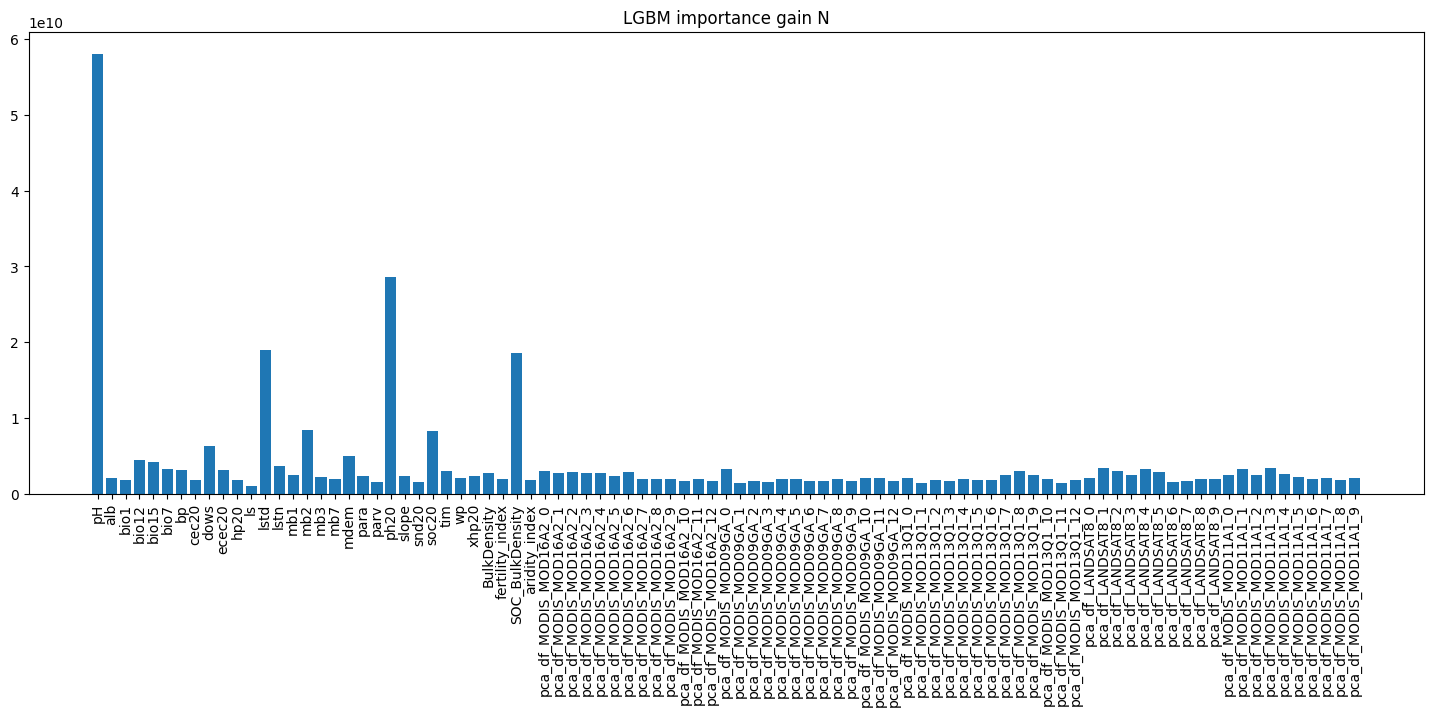

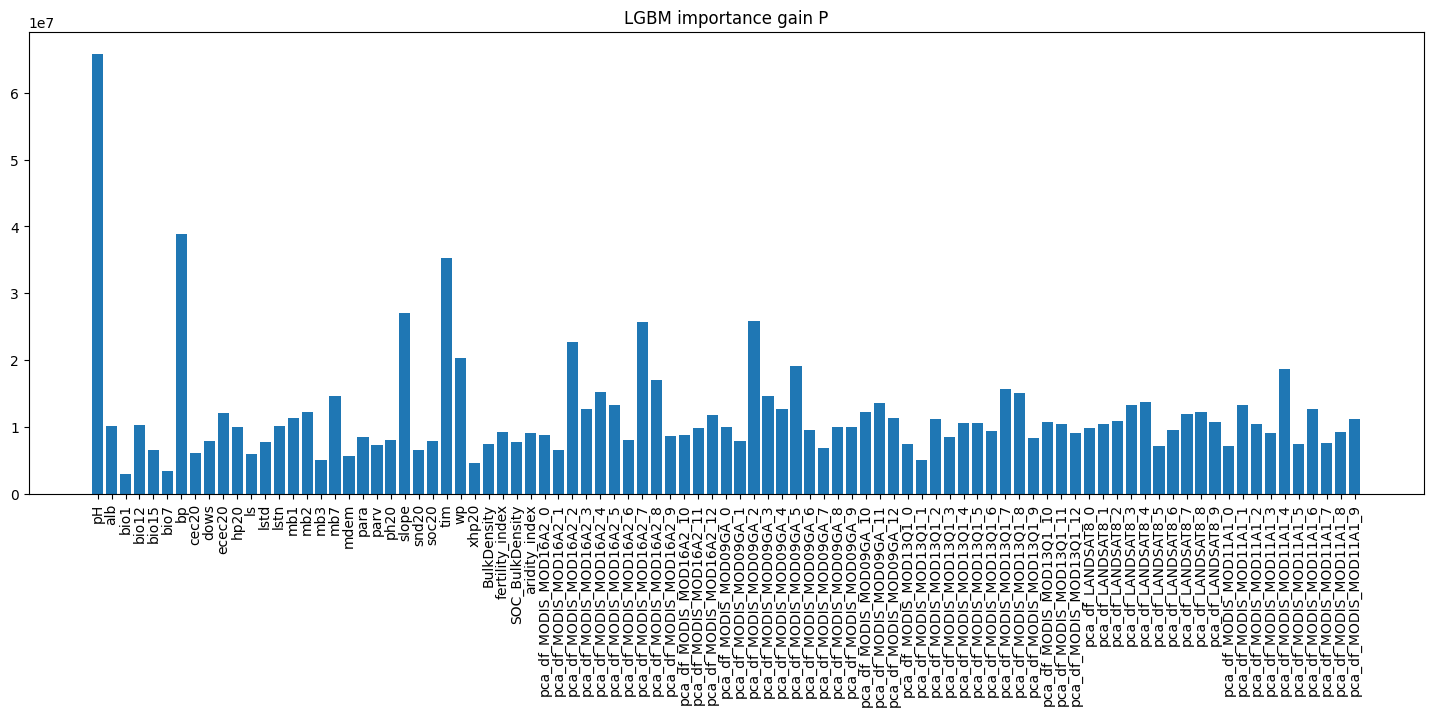

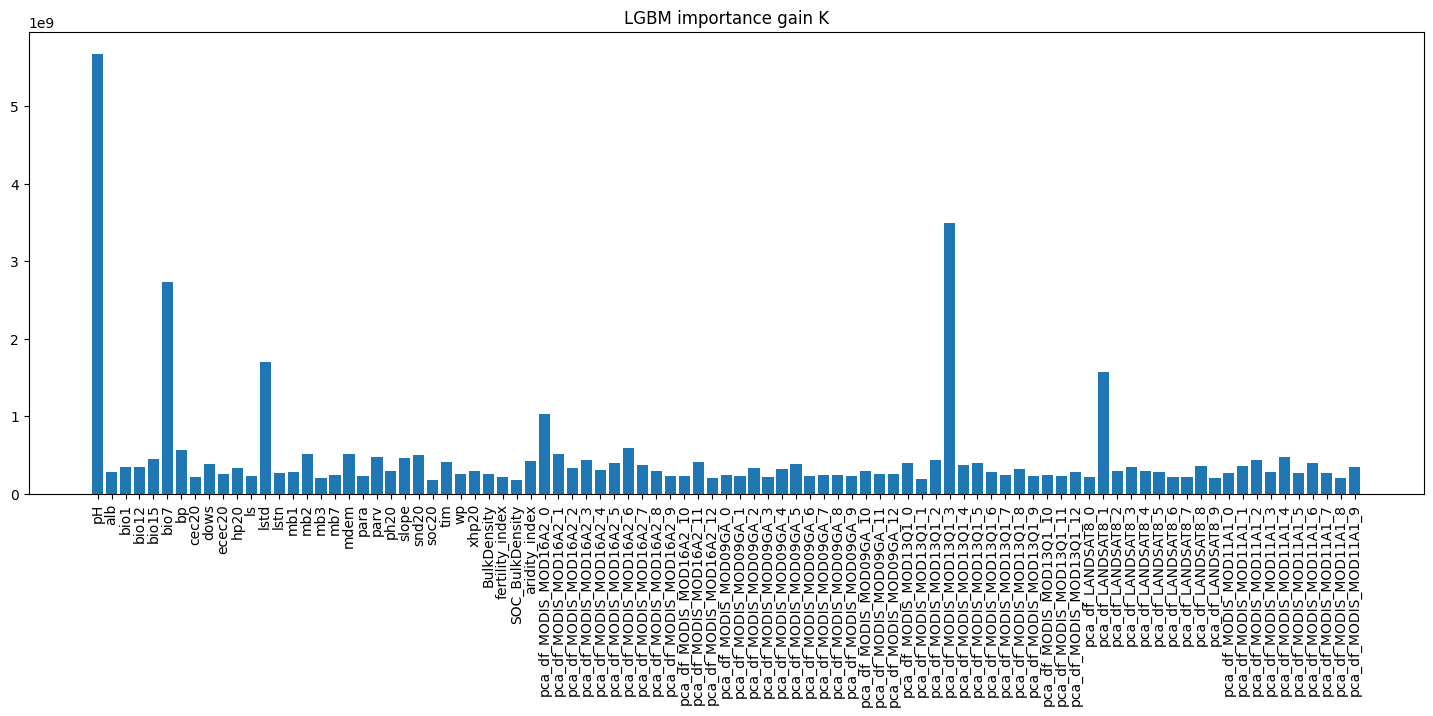

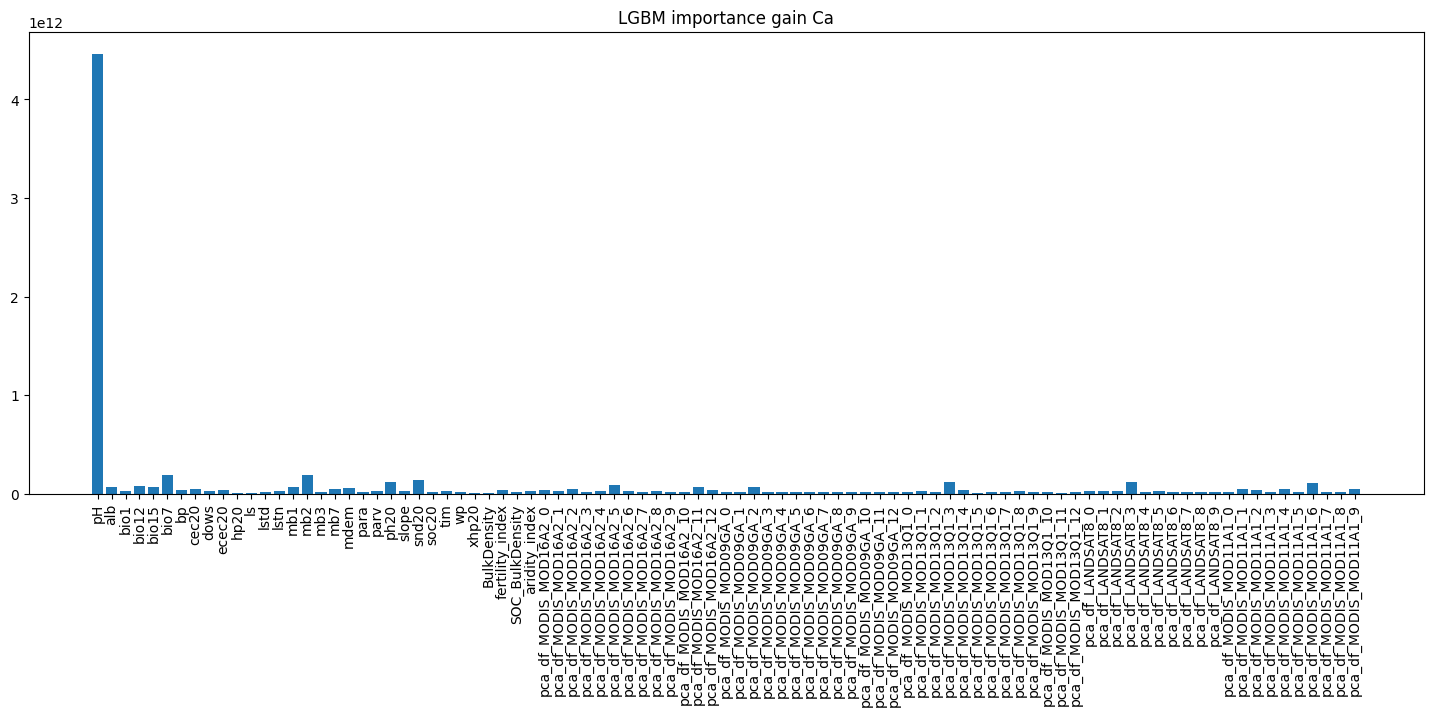

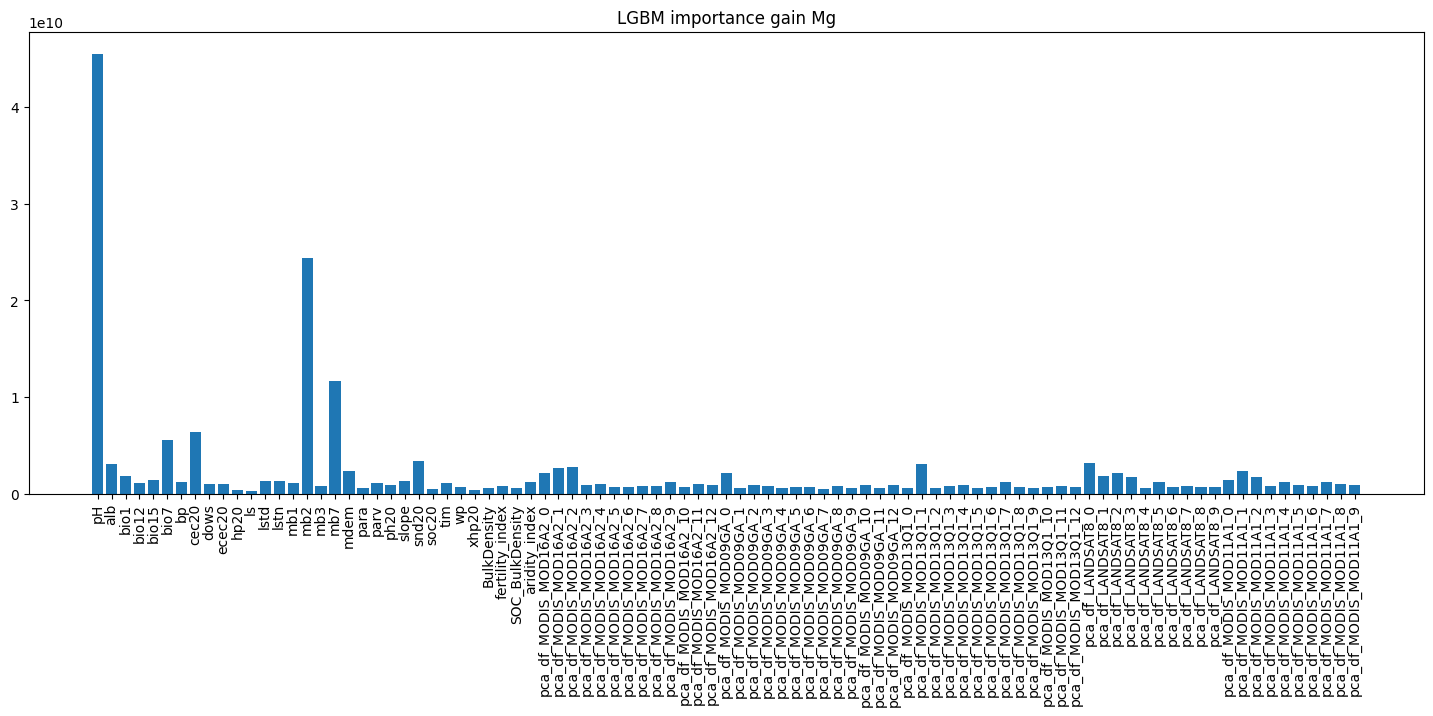

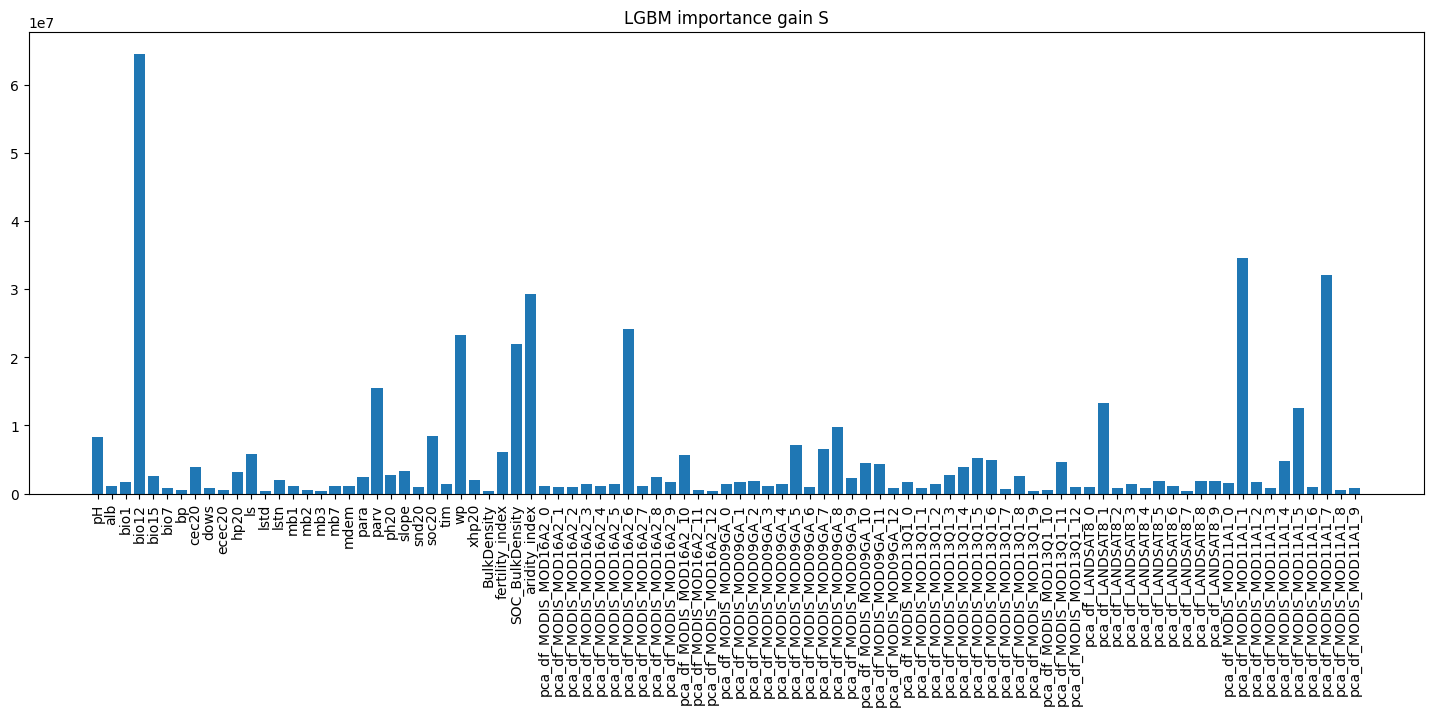

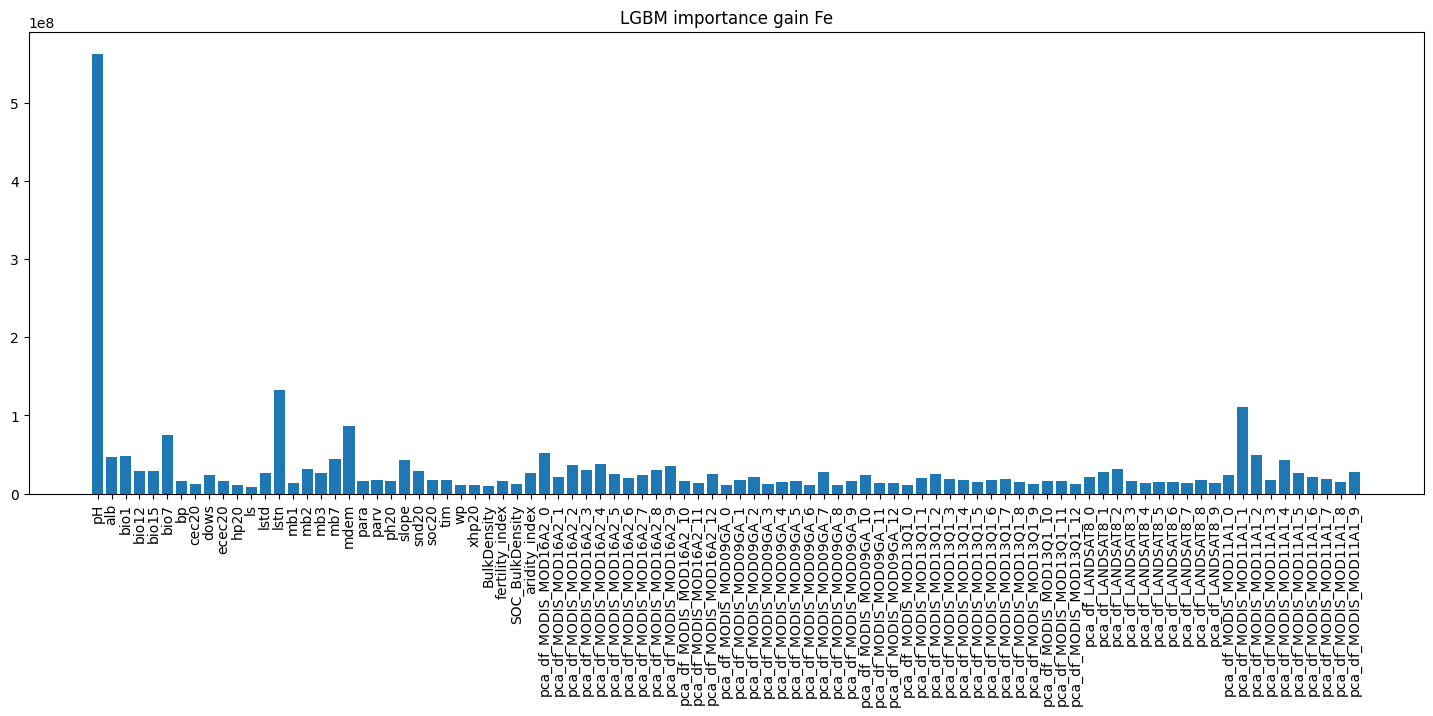

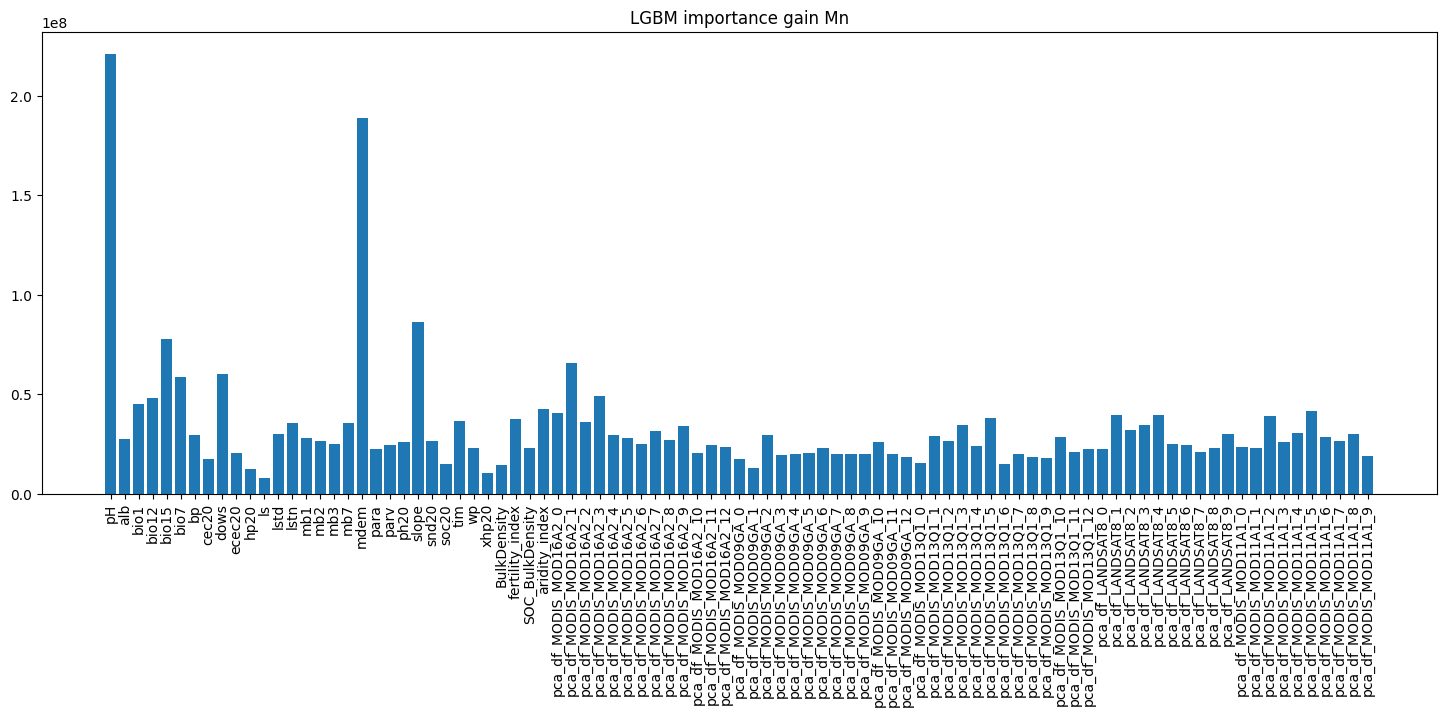

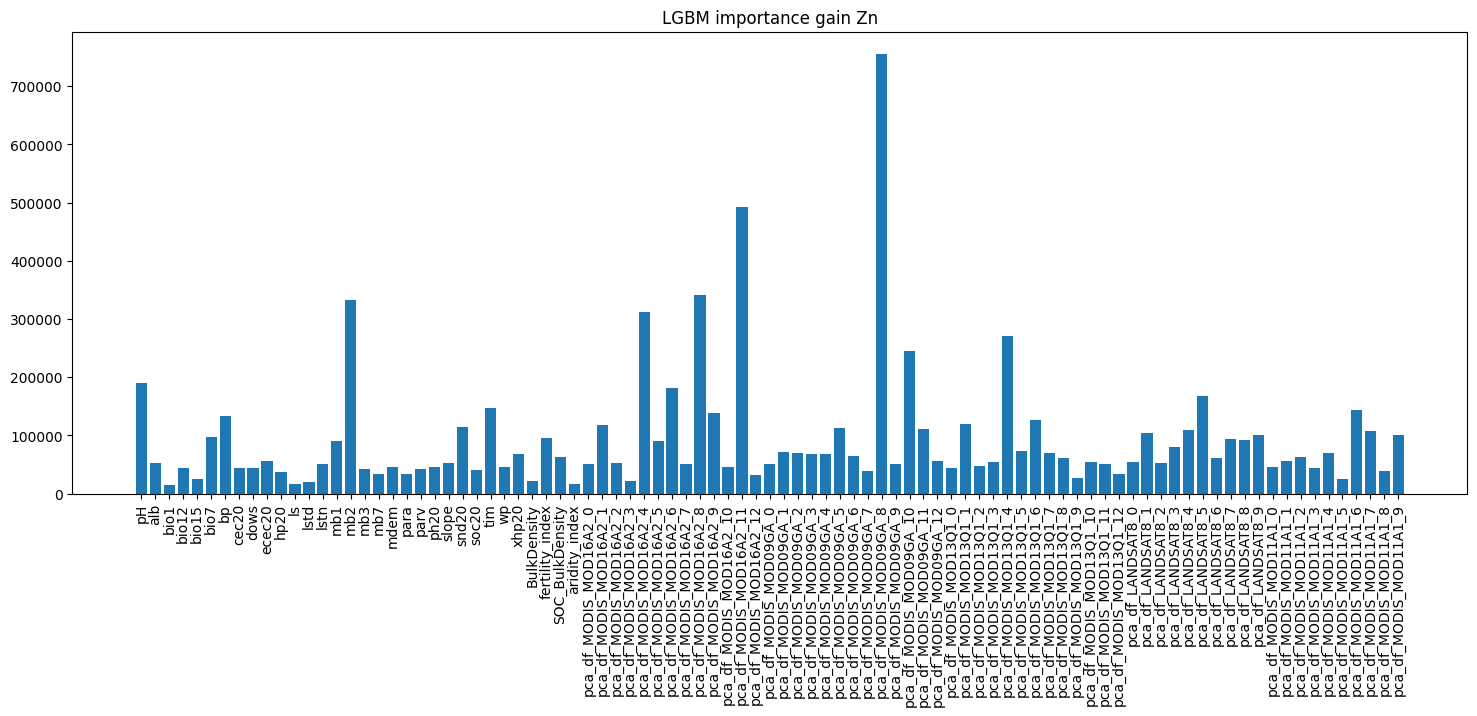

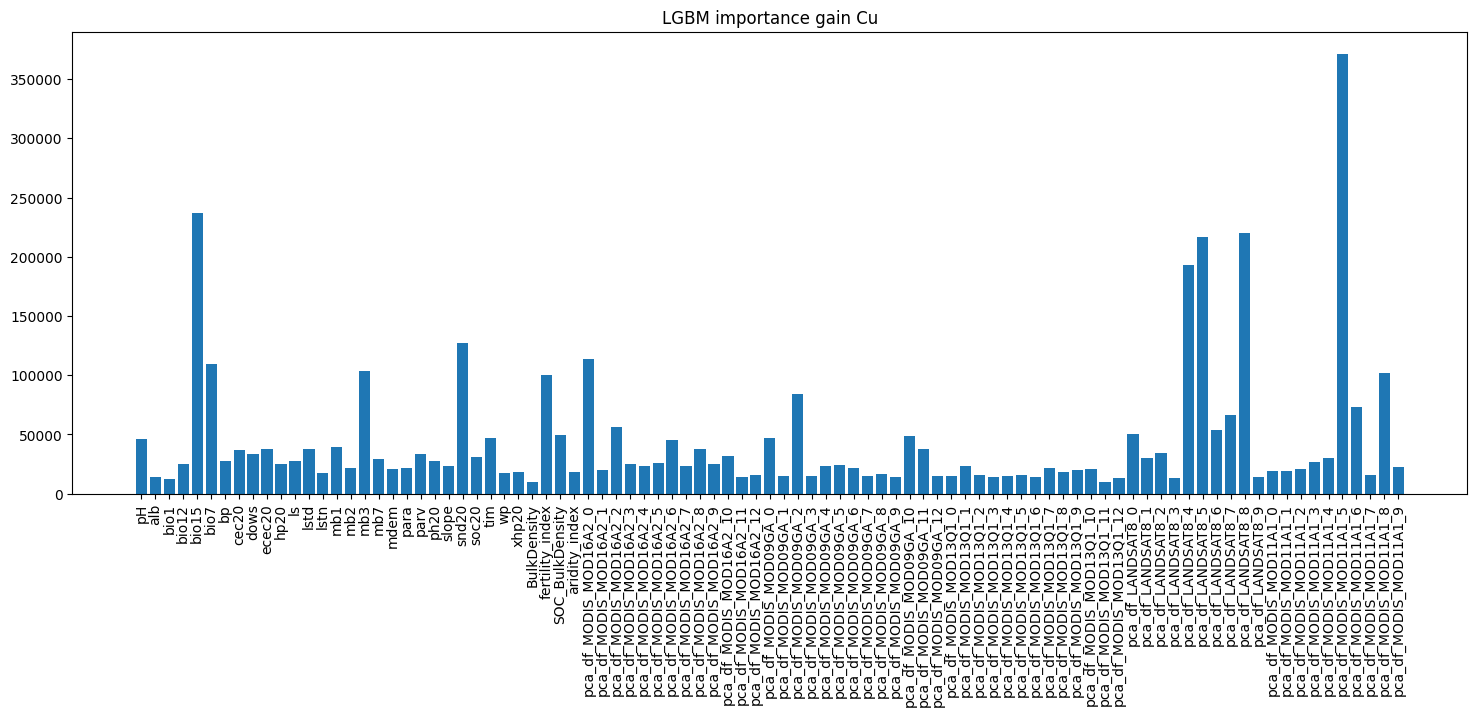

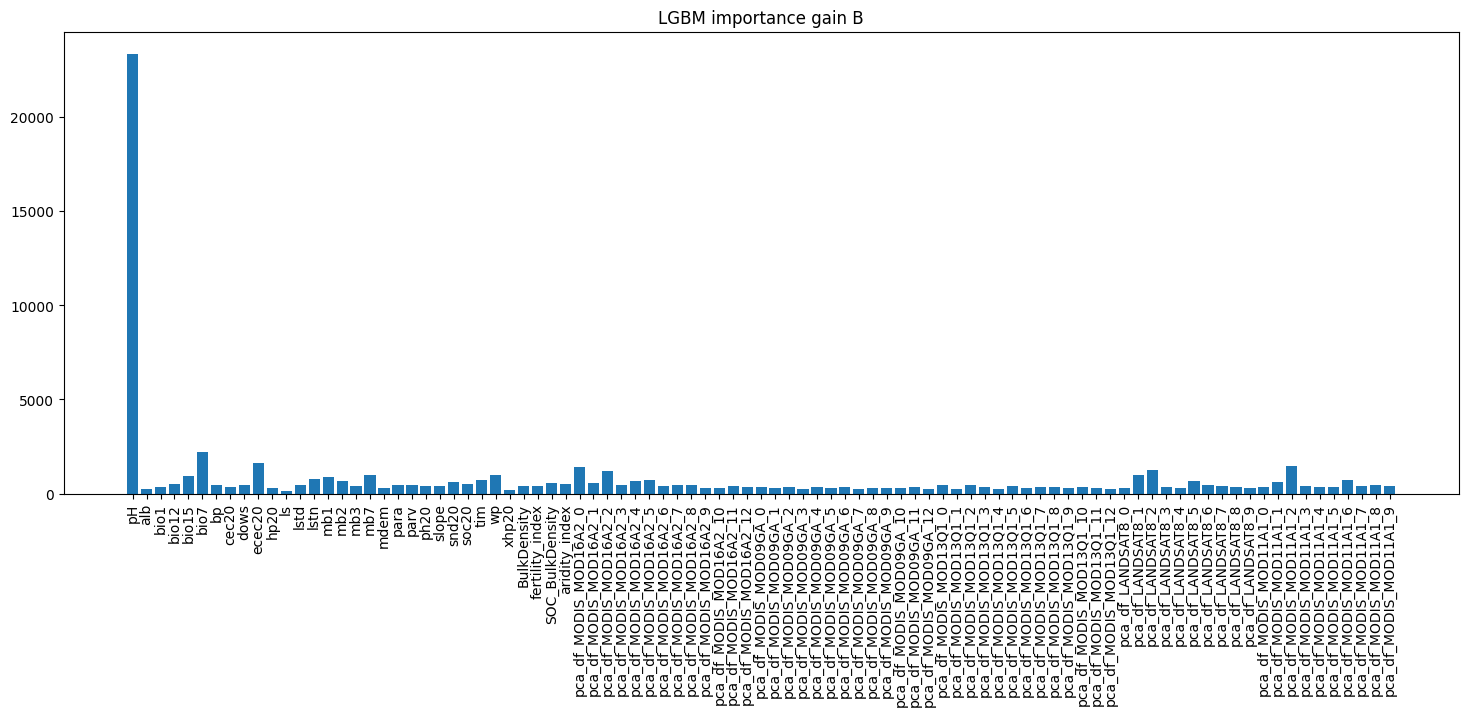

In [25]:

lgbm_impo=[]
for split in models_lgbm_cv:
  for i in range (0,11):
    
    importance = split[i].feature_importances_
    try:
      lgbm_impo[i]=lgbm_impo[i]+importance
    except:
      lgbm_impo.append(importance)
i=0
for importances in lgbm_impo:
    
    plt.figure(figsize=(18, 6))  # ancho=12, alto=6
    plt.bar(range(X_train.shape[1]), importances/5)
    plt.xticks(range(X_train.shape[1]), X_train.columns, rotation=90)
    plt.title("LGBM importance gain "+target_columns[i])
    plt.show()
    i=i+1

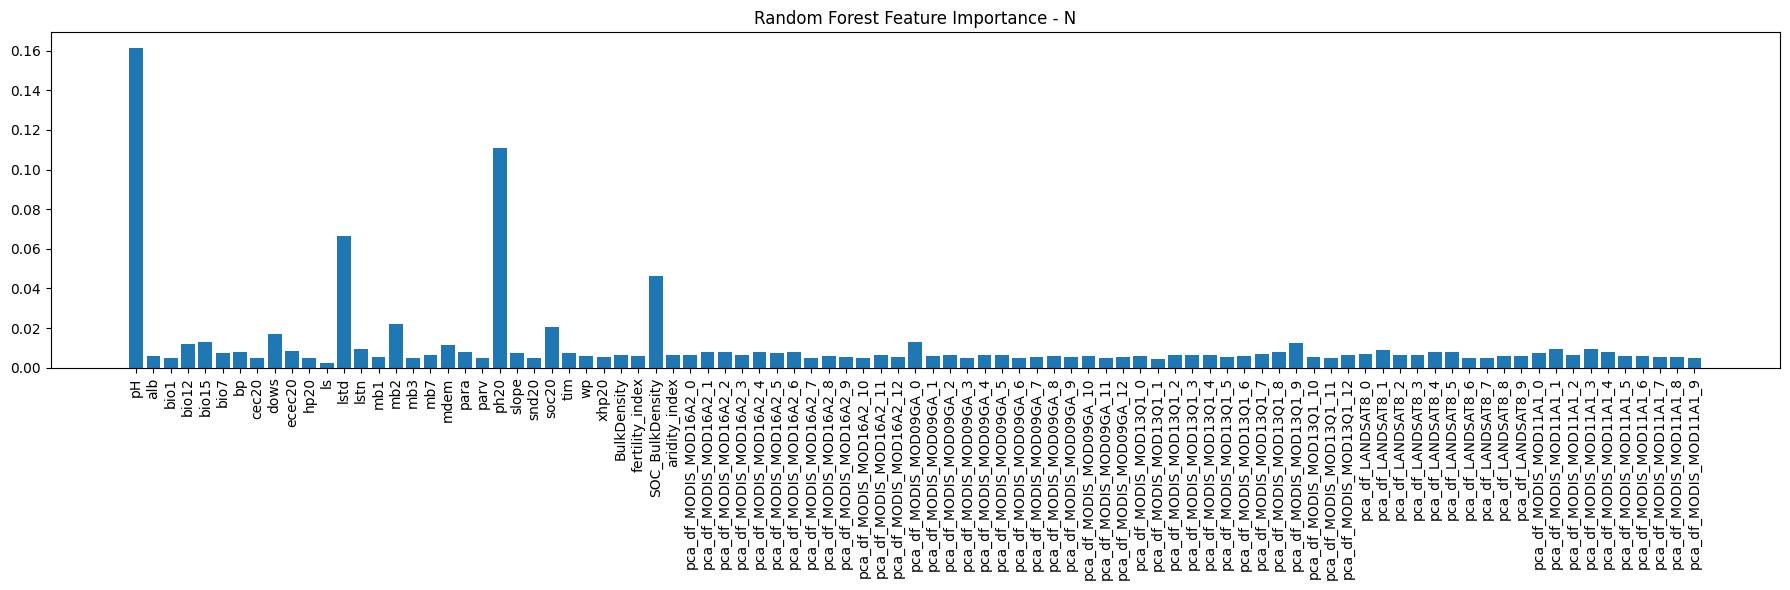

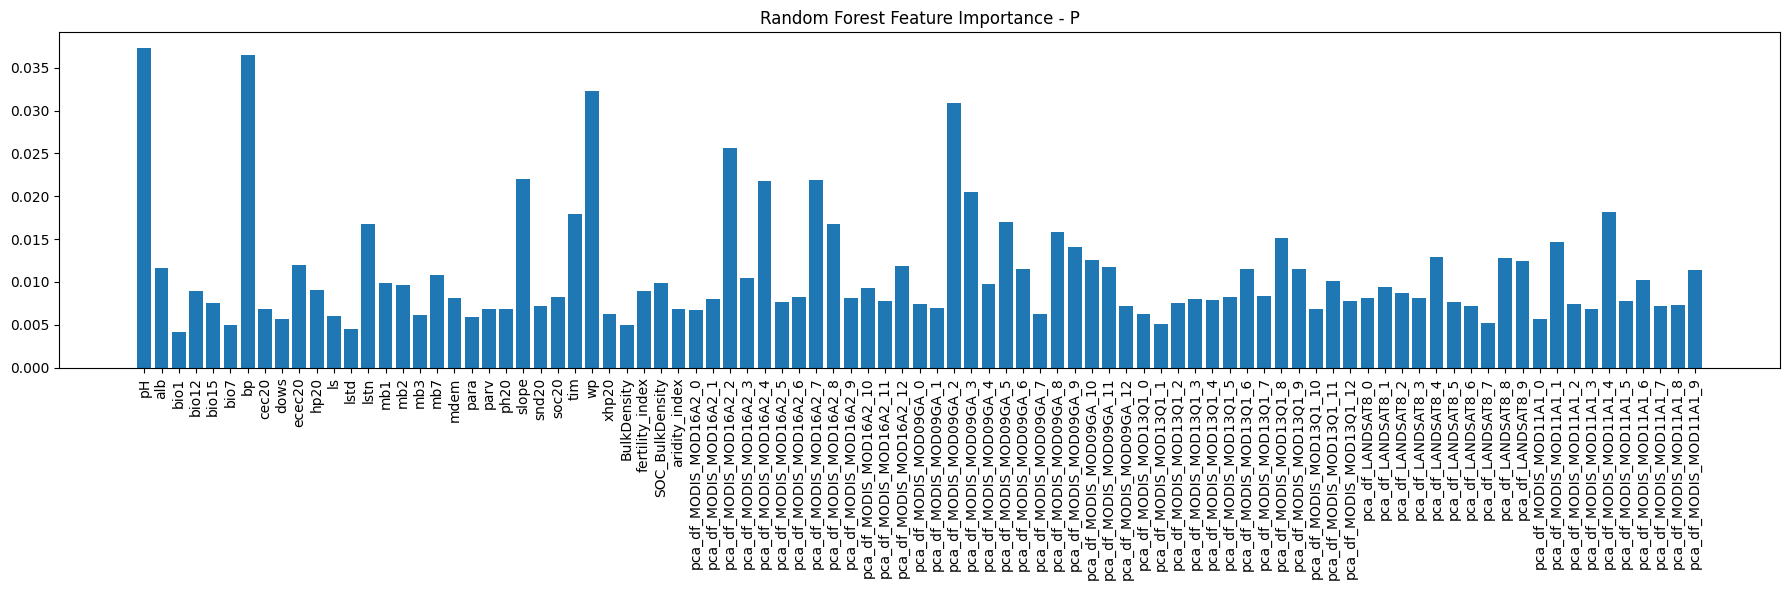

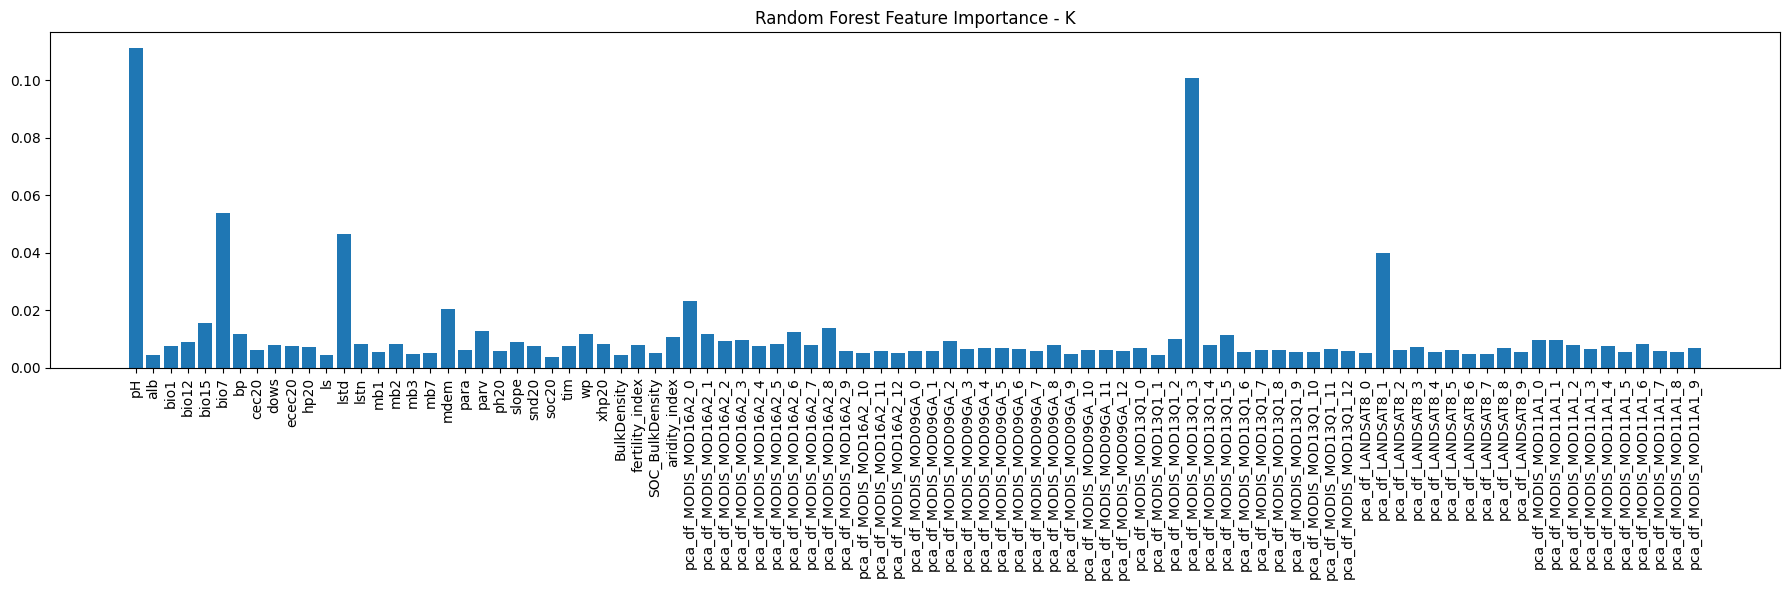

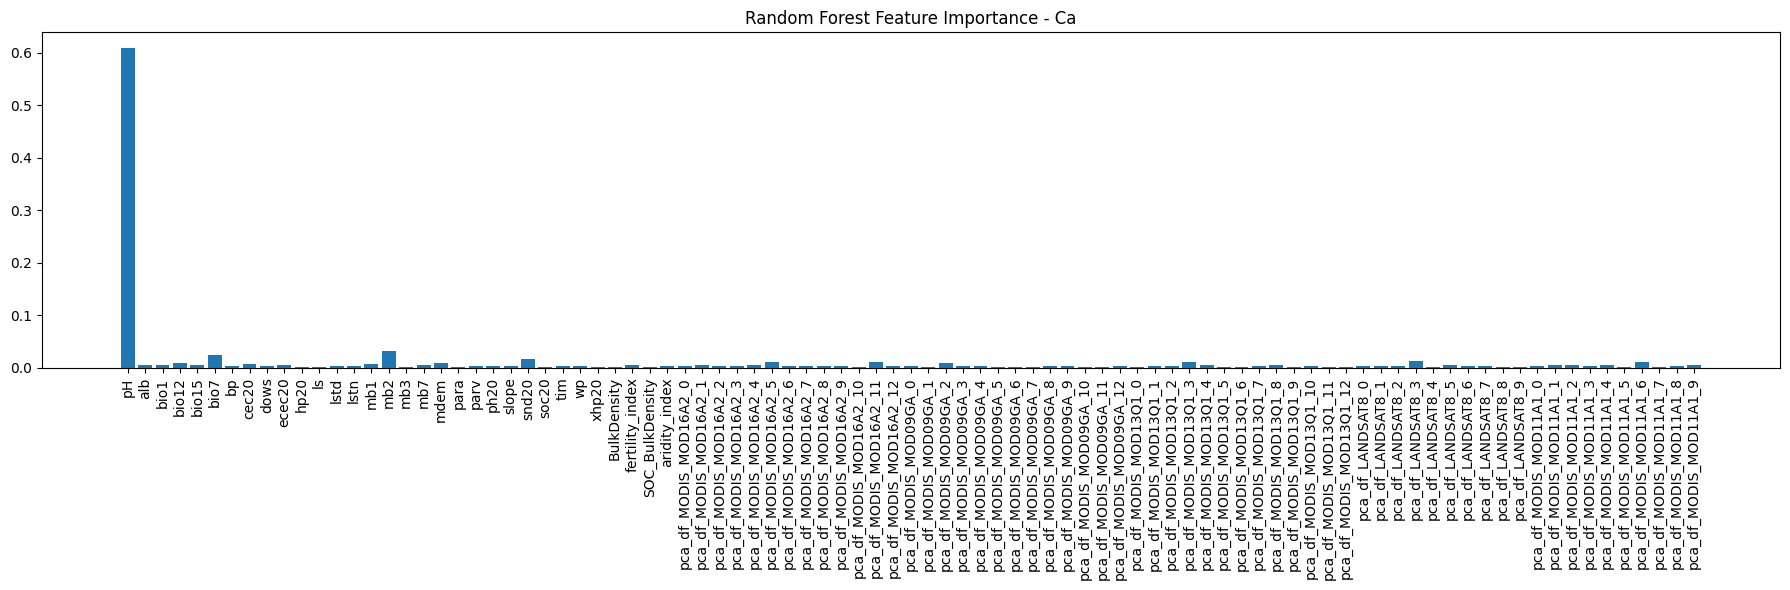

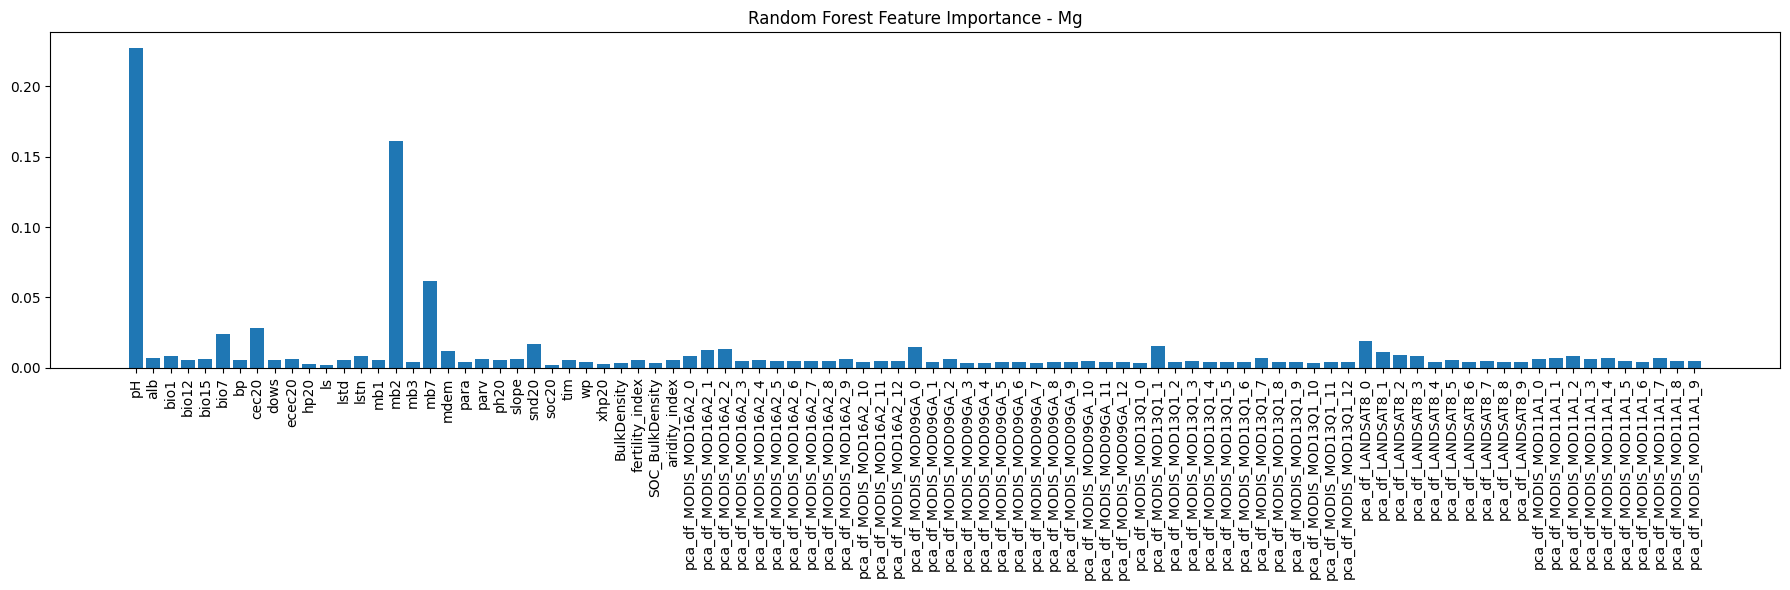

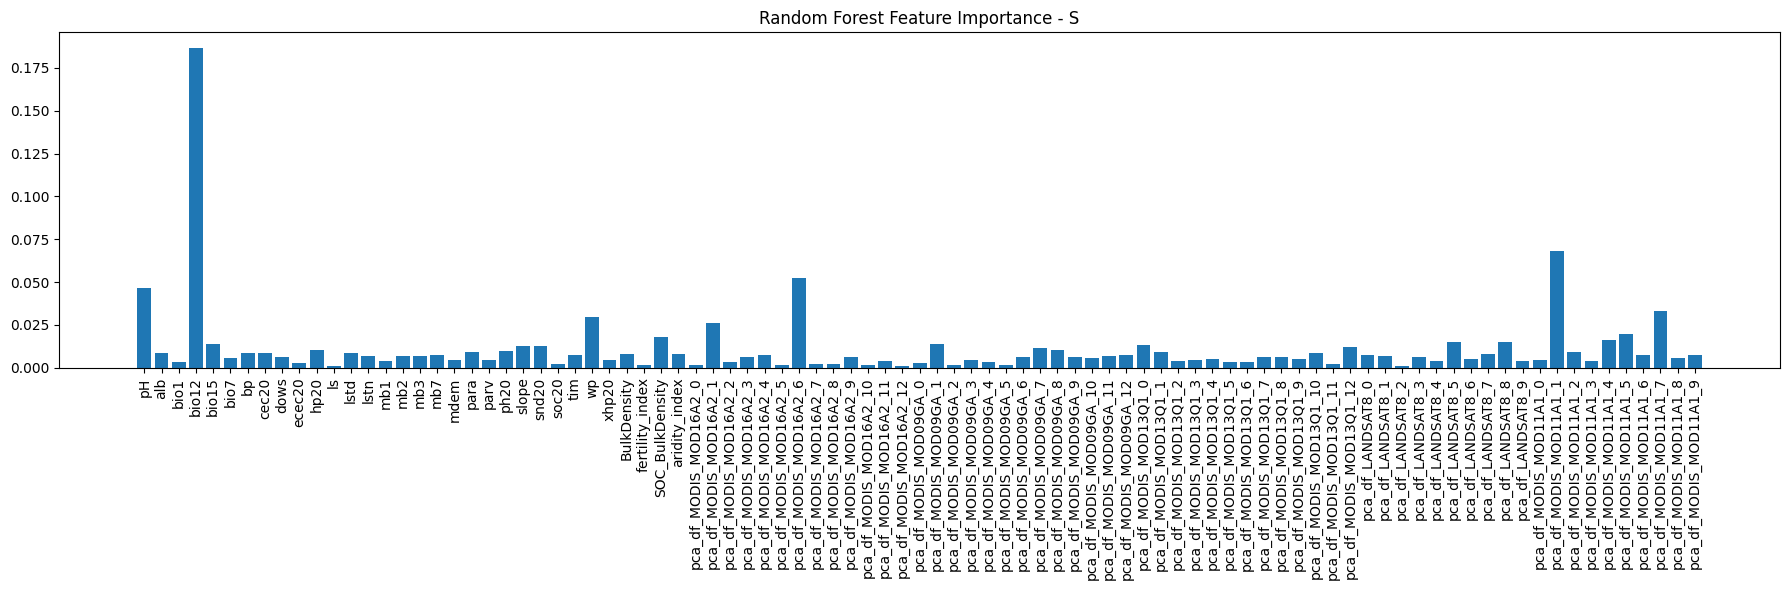

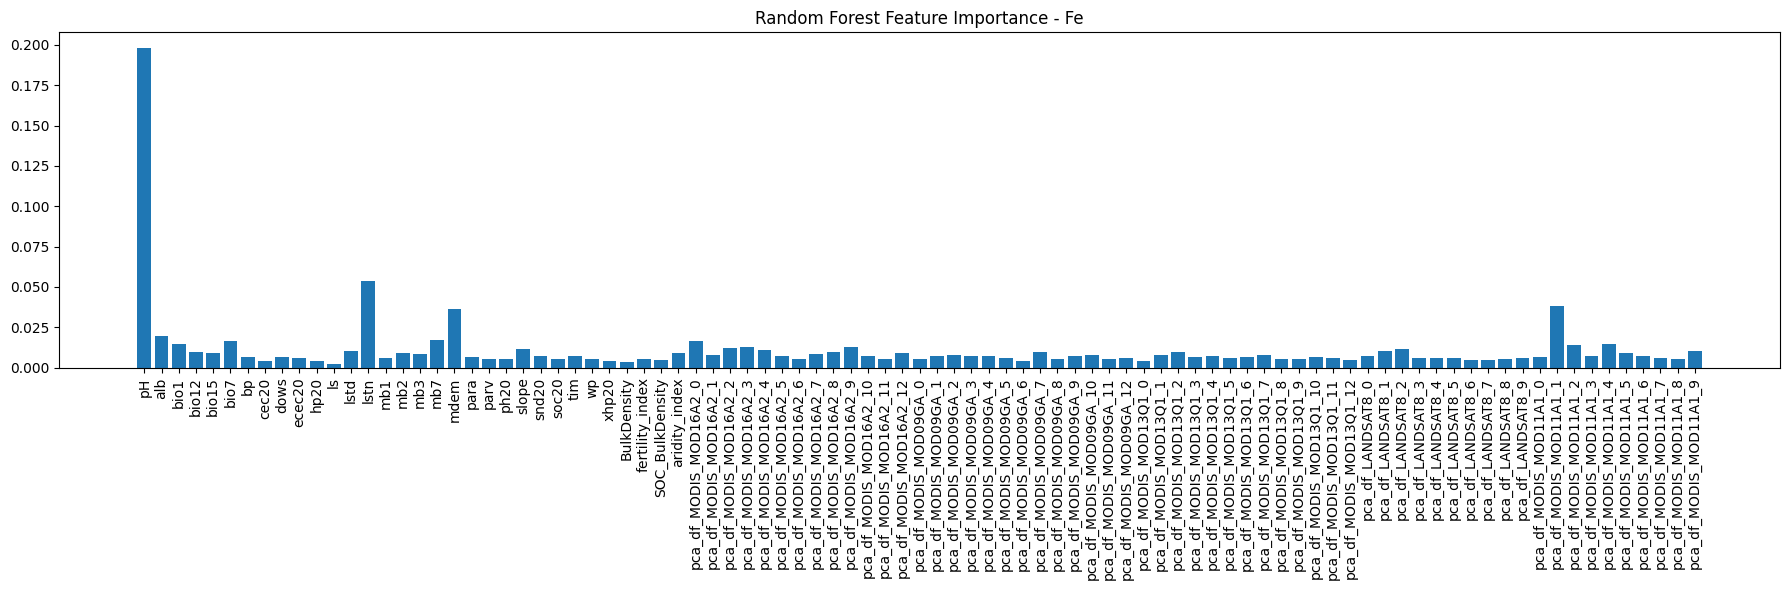

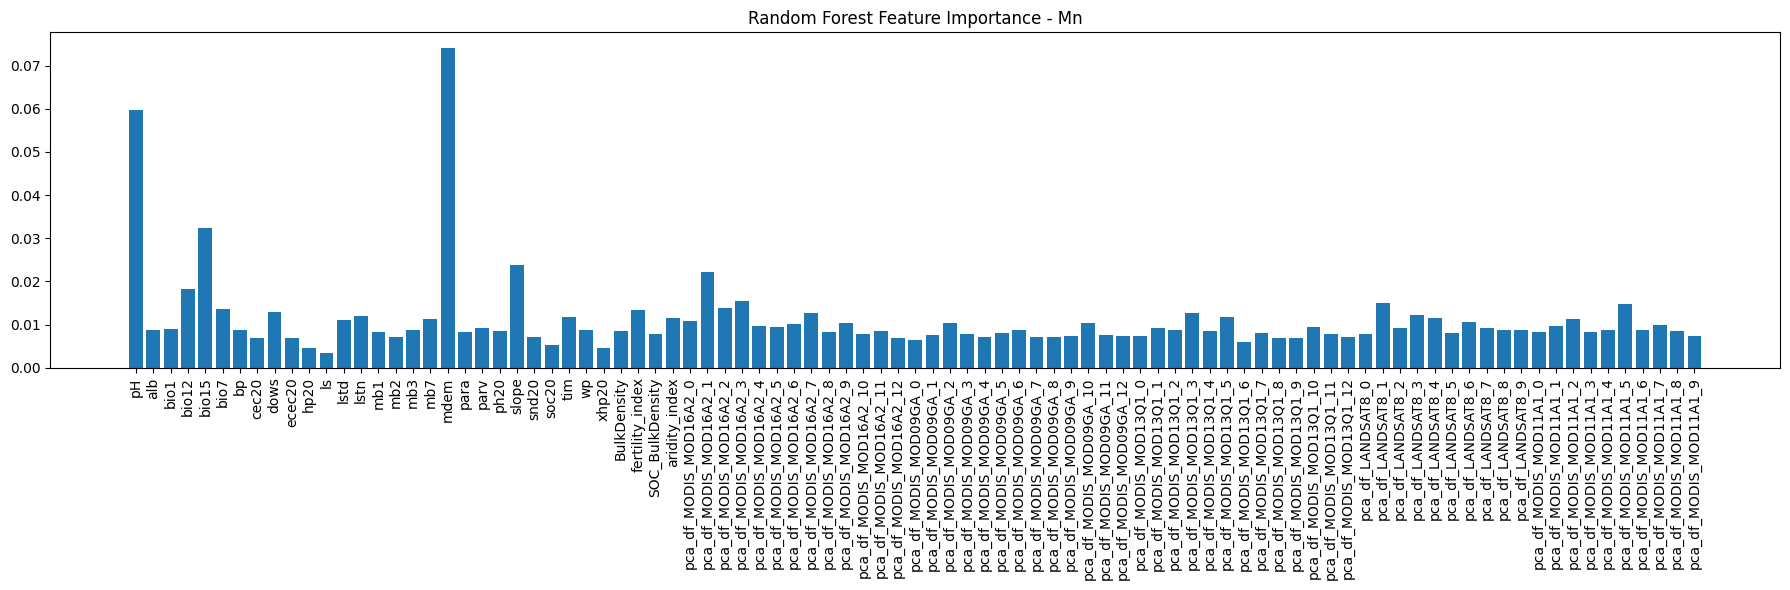

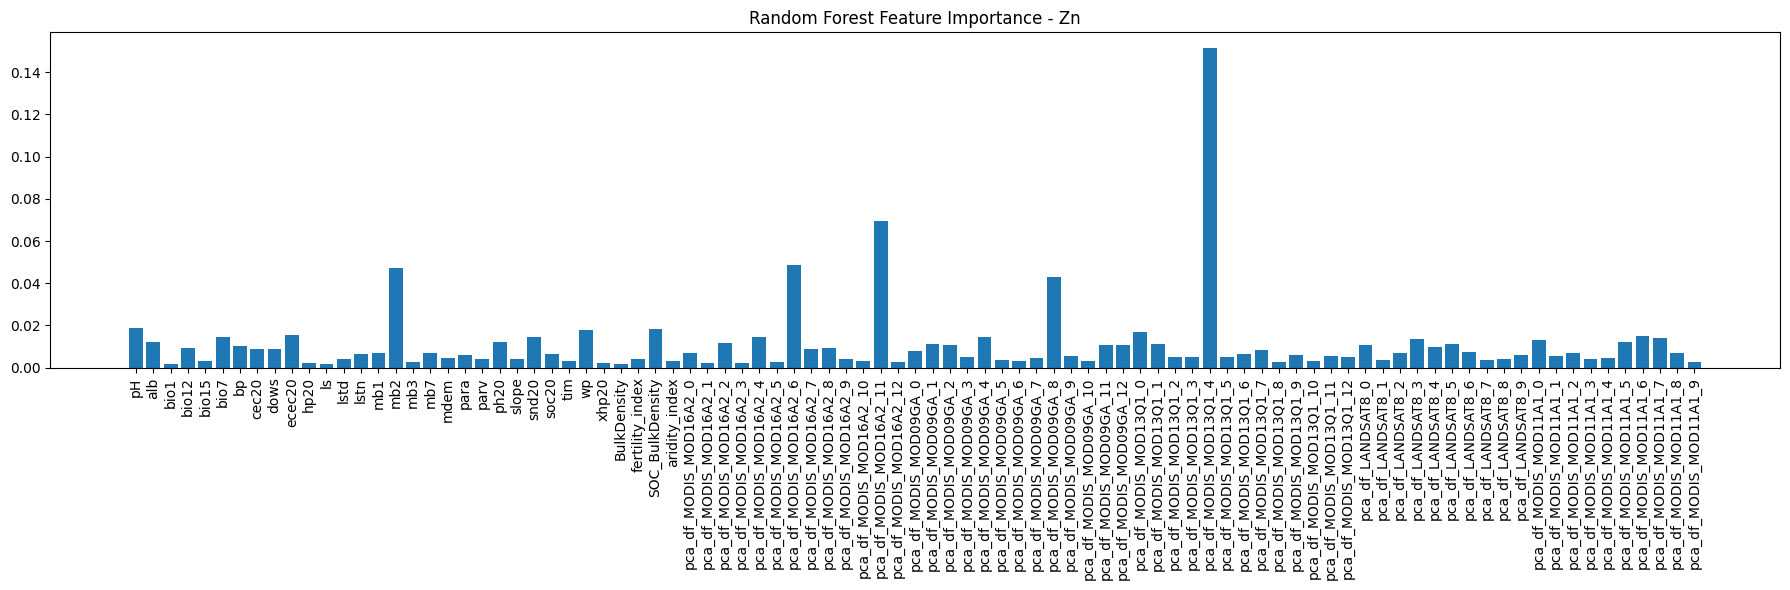

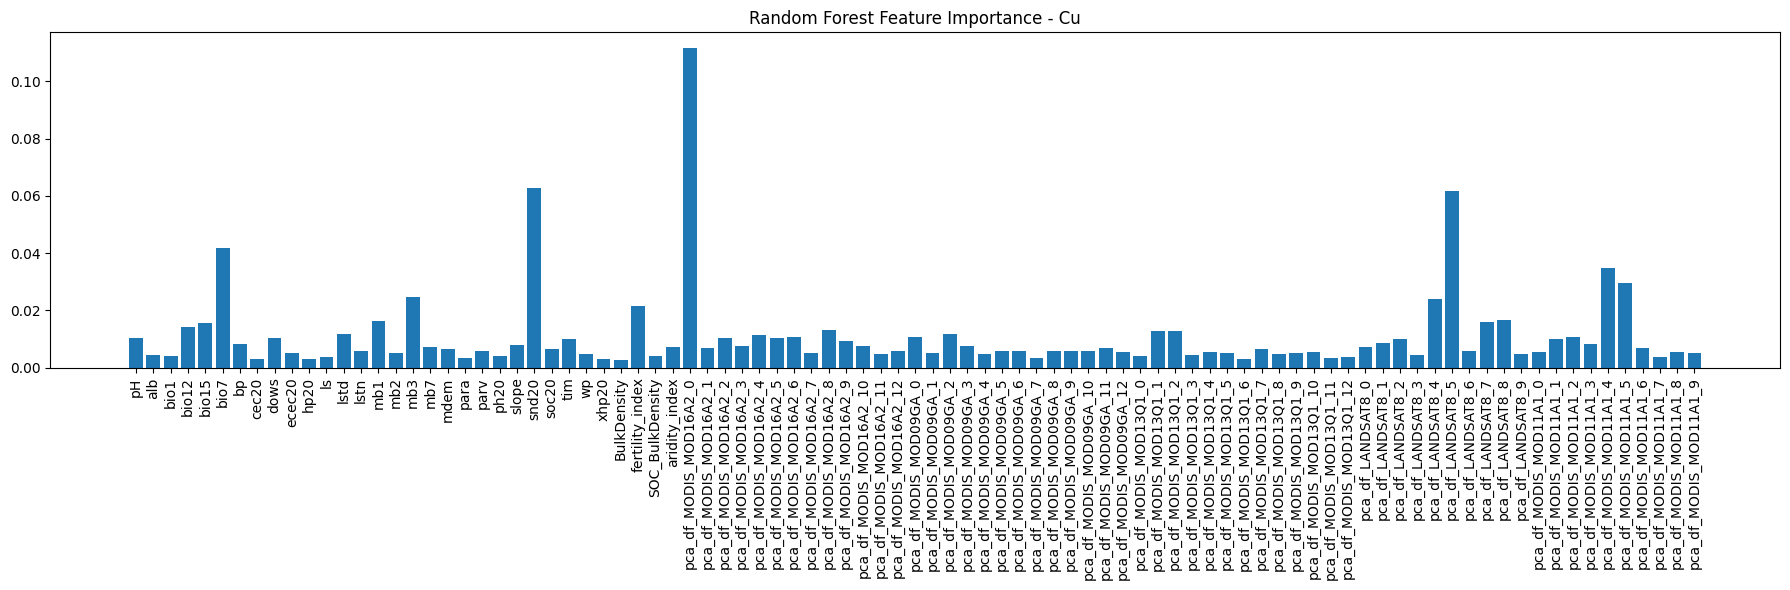

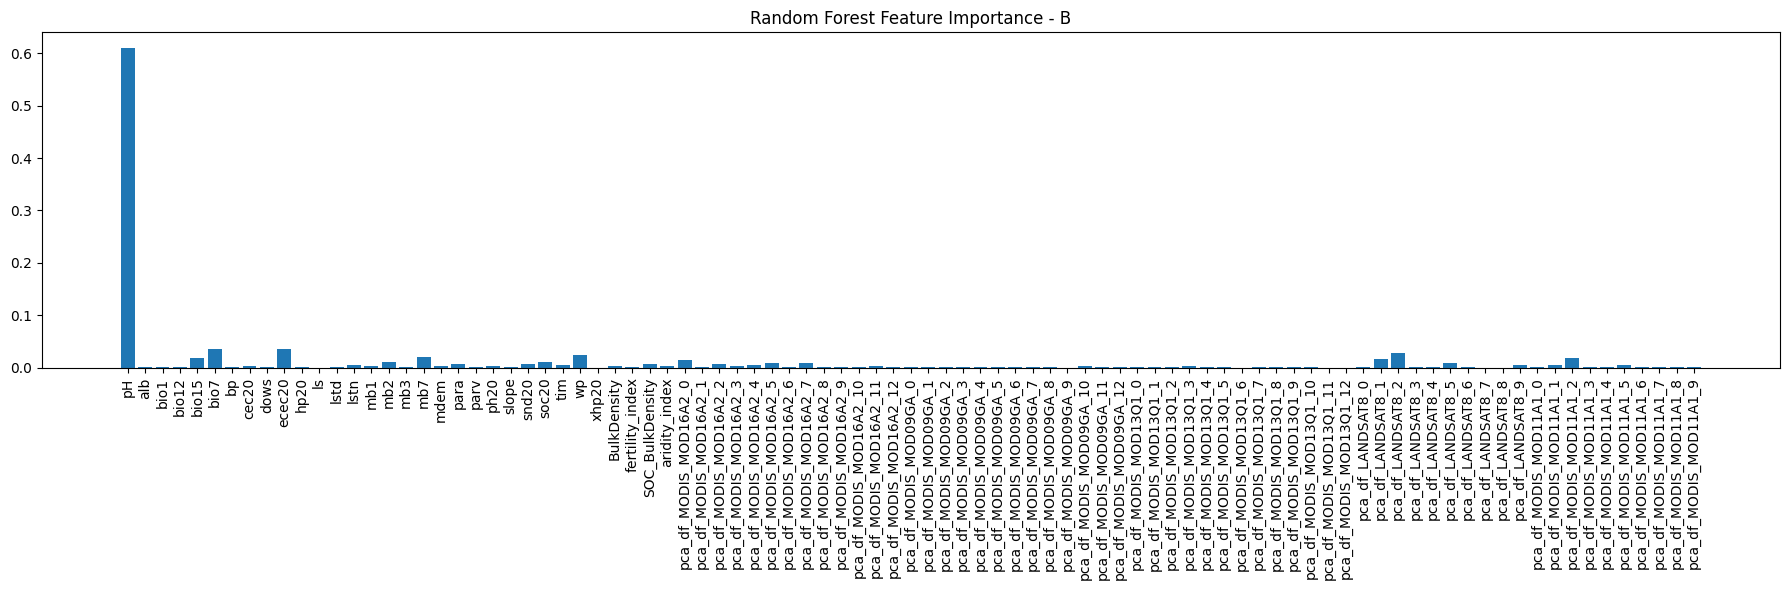

In [26]:


# Inicializar lista para acumular importancias por target
rf_impo = [np.zeros(X_train.shape[1]) for _ in range(len(target_columns))]

# Sumar importancias para cada target en cada modelo
for model in models_rf:
    for i, estimator in enumerate(model.estimators_):
        rf_impo[i] += estimator.feature_importances_

# Calcular promedio dividiendo por la cantidad de modelos (en este caso 5)
rf_impo_avg = [imp / len(models_rf) for imp in rf_impo]

# Graficar
for i, importances in enumerate(rf_impo_avg):
    plt.figure(figsize=(18, 6))
    plt.bar(range(X_train.shape[1]), importances)
    plt.xticks(range(X_train.shape[1]), X_train.columns, rotation=90)
    plt.title(f"Random Forest Feature Importance - {target_columns[i]}")
    plt.tight_layout()
    plt.show()
